In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import time
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice
from keras.models import load_model

register_matplotlib_converters()

Using TensorFlow backend.


In [3]:
# from local data file
trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# convert geohash into latitude longitude

In [7]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [8]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# weeks data

In [9]:
initial_day = 8 # change this to make a moving window
num_of_days = 28
end_day = initial_day + num_of_days
range_btwn_pts = 1 # in km
min_samples = 1
# get the entire data from day 1 to end_day
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= 1) & (trf_df_sort.day < end_day)])

In [10]:
trf_week1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
4168616,qp08bh,35,9:45,0.096850,2019-05-05 09:45:00,"(-5.46844482421875, 90.7086181640625)",-5.468445,90.708618
4176122,qp03re,35,9:45,0.220759,2019-05-05 09:45:00,"(-5.38604736328125, 90.6866455078125)",-5.386047,90.686646
4181516,qp0dj4,35,9:45,0.085532,2019-05-05 09:45:00,"(-5.25970458984375, 90.9283447265625)",-5.259705,90.928345
4184045,qp02zt,35,9:45,0.280343,2019-05-05 09:45:00,"(-5.46295166015625, 90.6866455078125)",-5.462952,90.686646
4198902,qp03mb,35,9:45,0.070707,2019-05-05 09:45:00,"(-5.40252685546875, 90.6097412109375)",-5.402527,90.609741


# initial day to end day cluster

In [11]:
day_ids = list(range(initial_day,end_day)) # generate day_id from initial day to end day
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day.isin(day_ids)])
latlon = trf_day1.groupby('geohash6')['geohash6'].unique().apply(lambda x: geohash.decode(x[0]))
coords = np.array([idx for idx in latlon])
#coords = trf_day1[['lat', 'lon']].values

In [12]:
start_time = time.time()
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
elapsed_time = time.time() - start_time
print('Time taken to cluster: {} secs'.format(elapsed_time))
print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Time taken to cluster: 0.04443979263305664 secs
Number of day 8 to day 35 clusters: 78


0     [[-5.48492431640625, 90.6536865234375], [-5.47...
1     [[-5.46295166015625, 90.6536865234375], [-5.45...
2     [[-5.48492431640625, 90.6646728515625], [-5.47...
3     [[-5.48492431640625, 90.6756591796875], [-5.47...
4     [[-5.48492431640625, 90.6866455078125], [-5.47...
5     [[-5.48492431640625, 90.6976318359375], [-5.47...
6     [[-5.41351318359375, 90.5877685546875], [-5.40...
7     [[-5.41351318359375, 90.5987548828125], [-5.40...
8     [[-5.41351318359375, 90.6097412109375], [-5.40...
9               [[-5.43548583984375, 90.6427001953125]]
10              [[-5.43548583984375, 90.6536865234375]]
11    [[-5.41351318359375, 90.6207275390625], [-5.40...
12    [[-5.41351318359375, 90.6317138671875], [-5.40...
13    [[-5.41351318359375, 90.6427001953125], [-5.40...
14    [[-5.41351318359375, 90.6536865234375], [-5.40...
15    [[-5.41900634765625, 90.6646728515625], [-5.41...
16    [[-5.30914306640625, 90.5987548828125], [-5.30...
17    [[-5.48492431640625, 90.7086181640625], [-

# cluster centermost_points

In [13]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (-5.48492431640625, 90.6536865234375)
1     (-5.45745849609375, 90.6536865234375)
2     (-5.45745849609375, 90.6646728515625)
3     (-5.36407470703125, 90.6756591796875)
4     (-5.36407470703125, 90.6866455078125)
5     (-5.36407470703125, 90.6976318359375)
6     (-5.36407470703125, 90.5877685546875)
7     (-5.36956787109375, 90.5987548828125)
8     (-5.35858154296875, 90.6097412109375)
9     (-5.43548583984375, 90.6427001953125)
10    (-5.43548583984375, 90.6536865234375)
11    (-5.35308837890625, 90.6207275390625)
12    (-5.34210205078125, 90.6317138671875)
13    (-5.32562255859375, 90.6427001953125)
14    (-5.32562255859375, 90.6536865234375)
15    (-5.32562255859375, 90.6646728515625)
16    (-5.30914306640625, 90.5987548828125)
17    (-5.36407470703125, 90.7086181640625)
18    (-5.35858154296875, 90.7196044921875)
19    (-5.40802001953125, 90.7305908203125)
20    (-5.45745849609375, 90.7415771484375)
21    (-5.46295166015625, 90.7525634765625)
22    (-5.46844482421875, 90.763

In [14]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [15]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
73,qp0d0t,8,0:0,0.014876,2019-04-08 00:00:00,"(-5.24322509765625, 90.7305908203125)",-5.243225,90.730591
74,qp0d44,28,9:45,0.003524,2019-04-28 09:45:00,"(-5.25970458984375, 90.7965087890625)",-5.259705,90.796509
75,qp0d4j,8,12:30,0.002965,2019-04-08 12:30:00,"(-5.24322509765625, 90.7965087890625)",-5.243225,90.796509
76,qp0d4q,8,0:30,0.046524,2019-04-08 00:30:00,"(-5.23773193359375, 90.8074951171875)",-5.237732,90.807495
77,qp0d5t,8,10:0,0.002340,2019-04-08 10:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427


# cluster member and centermost_point visualization

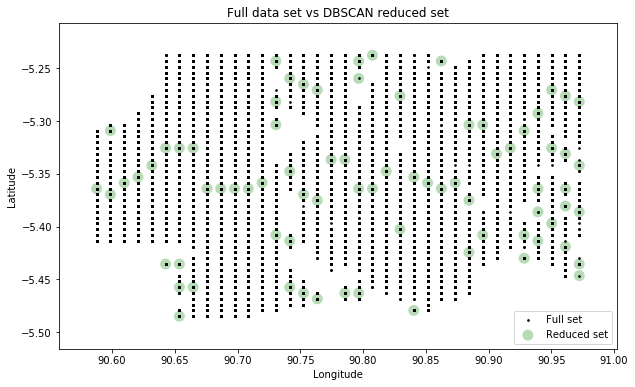

In [16]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [17]:
# map latlon clusters to geohash clusters
latlon_maps = {tuple(g): idx for idx,c in enumerate(clusters) for g in clusters[idx]}

# cluster_labels
trf_day1['cluster_ids'] = [latlon_maps[t] for t in trf_day1['latlon']]

In [18]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
7352,qp03zz,8,0:0,0.316994,2019-04-08,"(-5.27618408203125, 90.6976318359375)",-5.276184,90.697632,5
9502,qp096w,8,0:0,0.306831,2019-04-08,"(-5.36956787109375, 90.8184814453125)",-5.369568,90.818481,26
16226,qp09fh,8,0:0,0.024321,2019-04-08,"(-5.29266357421875, 90.7965087890625)",-5.292664,90.796509,40
19688,qp03w2,8,0:0,0.023814,2019-04-08,"(-5.35858154296875, 90.6317138671875)",-5.358582,90.631714,12
22060,qp09cy,8,0:0,0.023973,2019-04-08,"(-5.28167724609375, 90.7855224609375)",-5.281677,90.785522,37


In [19]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [20]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
2284376,qp0d5t,35,0:0,0.005595,2019-05-05 00:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
3882195,qp0d5t,35,0:30,0.000823,2019-05-05 00:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
3682318,qp0d5t,35,5:15,0.000446,2019-05-05 05:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
3649692,qp0d5t,35,11:30,0.002253,2019-05-05 11:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True
1562629,qp0d5t,35,12:45,0.001483,2019-05-05 12:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True


# set highest_demand and average demand to cluster

In [21]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [22]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
2284376,qp0d5t,35,0:0,0.005595,2019-05-05 00:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
3882195,qp0d5t,35,0:30,0.000823,2019-05-05 00:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
3682318,qp0d5t,35,5:15,0.000446,2019-05-05 05:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
3649692,qp0d5t,35,11:30,0.002253,2019-05-05 11:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
1562629,qp0d5t,35,12:45,0.001483,2019-05-05 12:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988


# visualize time, center point and highest demand

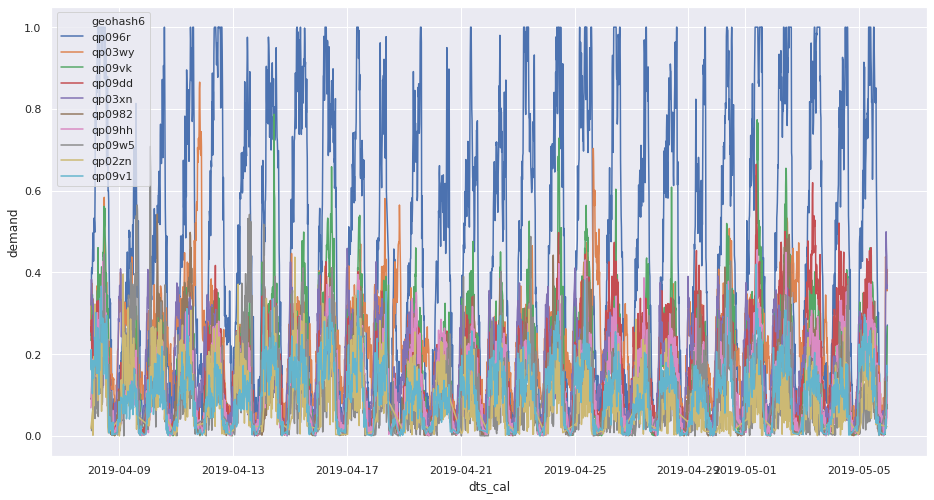

In [23]:
# observation 10 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:10]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

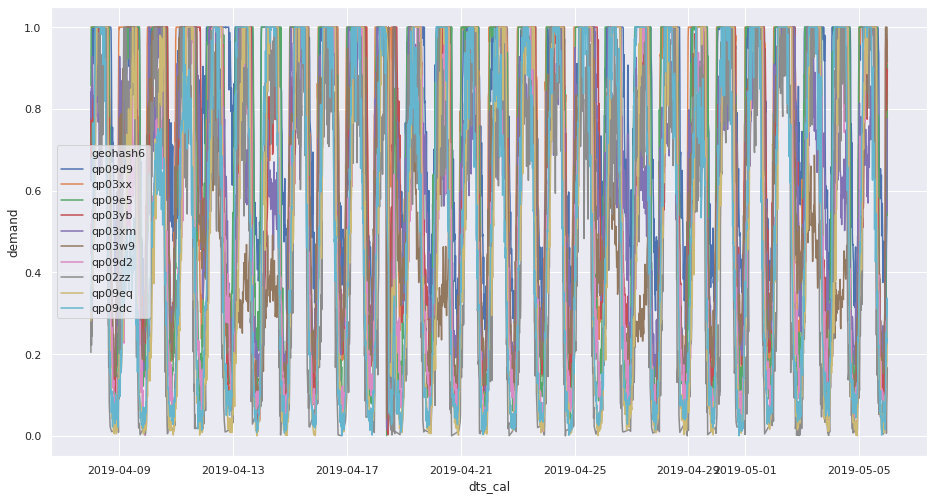

In [24]:
# observation 10 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:10]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [25]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [60]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = len(day_ids)
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})

# prepare time and date
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')

gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [initial_day + int(t/(24*4)) for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,8,0:0,0.623442,2019-04-08 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,26,False,True,0.834497
1,qp03xx,8,0:0,1.000000,2019-04-08 00:00:00,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646,4,False,True,0.749391
2,qp09e5,8,0:0,0.856622,2019-04-08 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,30,False,True,0.740044
3,qp03yb,8,0:0,0.777538,2019-04-08 00:00:00,"(-5.31463623046875, 90.6536865234375)",-5.314636,90.653687,14,False,True,0.693964
4,qp03xm,8,0:0,0.841489,2019-04-08 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,3,False,True,0.657692
5,qp03w9,8,0:0,0.718041,2019-04-08 00:00:00,"(-5.35308837890625, 90.6427001953125)",-5.353088,90.642700,13,False,True,0.612463
6,qp09d2,8,0:0,0.443884,2019-04-08 00:00:00,"(-5.35858154296875, 90.8074951171875)",-5.358582,90.807495,25,False,True,0.579350
7,qp02zz,8,0:0,0.204336,2019-04-08 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,5,False,True,0.562087
8,qp09eq,8,0:0,0.281660,2019-04-08 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,29,False,True,0.536701
9,qp09dc,8,0:0,0.306107,2019-04-08 00:00:00,"(-5.35308837890625, 90.8294677734375)",-5.353088,90.829468,27,False,True,0.527251


# visualize after zero fill gap

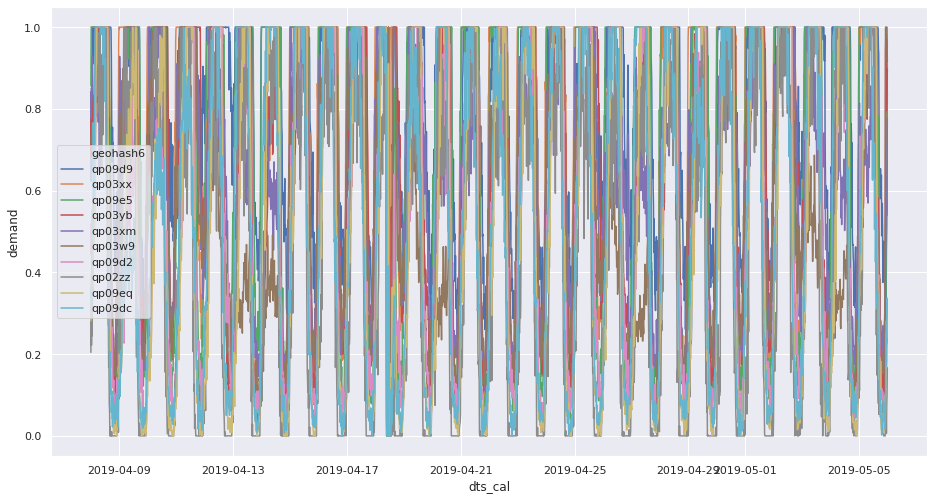

In [61]:
# observation 10 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:10]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [62]:
# prepare sorted data
total_sequence_series = 24*4*multiplier # 15 minutes within 24*multiplier hours
#past_length = int(((multiplier-1) / multiplier)*total_sequence_series)
prediction_length = int(24*4*(multiplier/2))
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
print("total_sequence_series: %s, prediction_length: %s" % (total_sequence_series, prediction_length))
trf_day1_complete_sort[-5:]

total_sequence_series: 2688, prediction_length: 1344


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
209347,qp0d5t,35,22:45,0.0,2019-05-05 22:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
209425,qp0d5t,35,23:0,0.0,2019-05-05 23:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
209503,qp0d5t,35,23:15,0.0,2019-05-05 23:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
209581,qp0d5t,35,23:30,0.0,2019-05-05 23:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988
209659,qp0d5t,35,23:45,0.0,2019-05-05 23:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,77,True,True,0.005988


In [63]:
# grouping and prepare prerequisite data
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

In [64]:
# weekly prediction using keras
from lib import keras_timeseries

# setup train and test data for keras
train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]
test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[total_sequence_series-prediction_length:]] for c in cluster_list]

X_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in train_day1_ds]))
X_data = X_mat.round(15).reshape(len(cluster_list), total_sequence_series-prediction_length, 1)
y_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in test_day1_ds]))
y_data = y_mat.round(15).reshape(len(cluster_list), prediction_length, 1)

test_count = int(0.5*X_data.shape[0])
test_count = test_count if test_count < 32 else 32*ceil(test_count / 32)
X_train = X_data[:-(X_data.shape[0]-test_count)]
X_test = X_data[X_data.shape[0]-test_count:]

#print(X_train.shape, X_test.shape)

y_train = y_data[:-(y_data.shape[0]-test_count)]
y_test = y_data[y_data.shape[0]-test_count:]

#print(y_train.shape, y_test.shape)

N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
train_batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 24 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series
test_batch_size = X_test.shape[0]

inputs, outputs = \
    [keras_timeseries.stateful_cut(arr, train_batch_size, T_after_cut) for arr in \
    [X_train, y_train]]
inputs_test, outputs_test = \
    [keras_timeseries.stateful_cut(arr, test_batch_size, T_after_cut) for arr in \
    [X_test, y_test]]
#inputs, outputs, inputs_test, outputs_testtest_count = test_count if test_count < 32 else 32*ceil(test_count / 32)

Train on 3584 samples, validate on 3584 samples
Epoch 1/500
3584/3584 [==============================] - 1s 392us/step - loss: 0.1251 - val_loss: 0.0769
Epoch 2/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0901 - val_loss: 0.0594
Epoch 3/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0691 - val_loss: 0.0474
Epoch 4/500
3584/3584 [==============================] - 1s 220us/step - loss: 0.0540 - val_loss: 0.0372
Epoch 5/500
3584/3584 [==============================] - 1s 218us/step - loss: 0.0407 - val_loss: 0.0270
Epoch 6/500
3584/3584 [==============================] - 1s 248us/step - loss: 0.0284 - val_loss: 0.0191
Epoch 7/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0208 - val_loss: 0.0152
Epoch 8/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0172 - val_loss: 0.0132
Epoch 9/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0153 - val_loss: 0.0120
Epoch 1

Epoch 78/500
3584/3584 [==============================] - 1s 226us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 79/500
3584/3584 [==============================] - 1s 225us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 80/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 81/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 82/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 83/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 84/500
3584/3584 [==============================] - 1s 227us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 85/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 86/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 87/500
3584/3584 [======================

Epoch 155/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 156/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 157/500
3584/3584 [==============================] - 1s 235us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 158/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 159/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 160/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 161/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 162/500
3584/3584 [==============================] - 1s 219us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 163/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 164/500
3584/3584 [============

3584/3584 [==============================] - 1s 202us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 232/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 233/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 234/500
3584/3584 [==============================] - 1s 214us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 235/500
3584/3584 [==============================] - 1s 202us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 236/500
3584/3584 [==============================] - 1s 257us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 237/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 238/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 239/500
3584/3584 [==============================] - 1s 202us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 240/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 233us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 308/500
3584/3584 [==============================] - 1s 227us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 309/500
3584/3584 [==============================] - 1s 200us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 310/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 311/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 312/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 313/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 314/500
3584/3584 [==============================] - 1s 229us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 315/500
3584/3584 [==============================] - 1s 218us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 316/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 206us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 384/500
3584/3584 [==============================] - 1s 202us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 385/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 386/500
3584/3584 [==============================] - 1s 215us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 387/500
3584/3584 [==============================] - 1s 215us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 388/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 389/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 390/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 391/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 392/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 242us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 460/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 461/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 462/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 463/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 464/500
3584/3584 [==============================] - 1s 214us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 465/500
3584/3584 [==============================] - 1s 227us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 466/500
3584/3584 [==============================] - 1s 220us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 467/500
3584/3584 [==============================] - 1s 208us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 468/500
3584/3584 [==========================

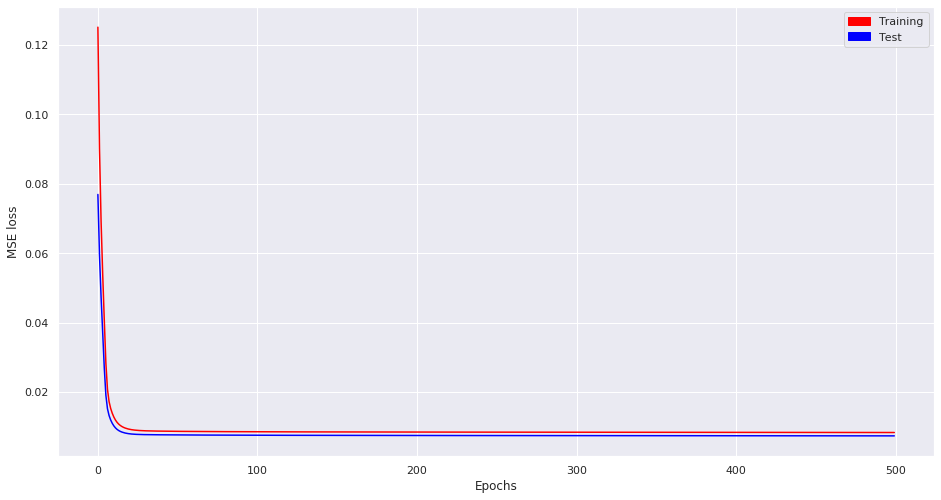

In [65]:
# building network and training
model = keras_timeseries.build_model(train_batch_size, int(total_sequence_series/T), dim_in, dim_out, T_after_cut)
epochs = 500
history = keras_timeseries.train_model(model, inputs, outputs, inputs_test, outputs_test,
                N, T, epochs, train_batch_size, test_batch_size, T_after_cut)
keras_timeseries.plotting(history)

# saving the model
model_path = 'model/keras-epoch%s-stateful-init%s-%sdays.lstm' % (epochs, initial_day, len(day_ids))
model.save(model_path)

In [66]:
# predicting and evaluating
model = load_model(model_path)

interval=64
first_idx = range(0, interval)
second_idx = range(len(cluster_list)-interval, len(cluster_list))

first_x = X_data[first_idx]
first_y = y_data[first_idx]
first_yhat = model.predict(first_x, batch_size=interval)

second_x = X_data[second_idx]
second_y = y_data[second_idx]
second_yhat = model.predict(second_x, batch_size=interval)

actual_x = [first_x[c] for c in first_idx]
actual_x.extend([second_x[c] for c in range(interval-(len(cluster_list)-interval), interval)])
actual_y = [first_y[c] for c in first_idx]
actual_y.extend([second_y[c] for c in range(interval-(len(cluster_list)-interval), interval)])
predicted_y = [first_yhat[c] for c in first_idx]
predicted_y.extend([second_yhat[c] for c in range(interval-(len(cluster_list)-interval), interval)])

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'cluster_ids': [],
    'ts': []})

actual_x_df = pd.DataFrame([actual_x[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
actual_y_df = pd.DataFrame([actual_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
predicted_x_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in cluster_list])
predicted_y_df = pd.DataFrame([predicted_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])

result_df['cluster_ids'] = [c for _ in interval_time for c in cluster_list]
result_df['ts'] = [start_date + t for t in interval_time for _ in cluster_list]
actual_result = actual_x_df.append(actual_y_df)
predicted_result = predicted_x_df.append(predicted_y_df)
result_df = result_df.sort_values(['ts', 'cluster_ids'])
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

#result_df[result_df.cluster_ids == 0]
top_result_df = result_df[result_df.cluster_ids.isin(top_clusters)]

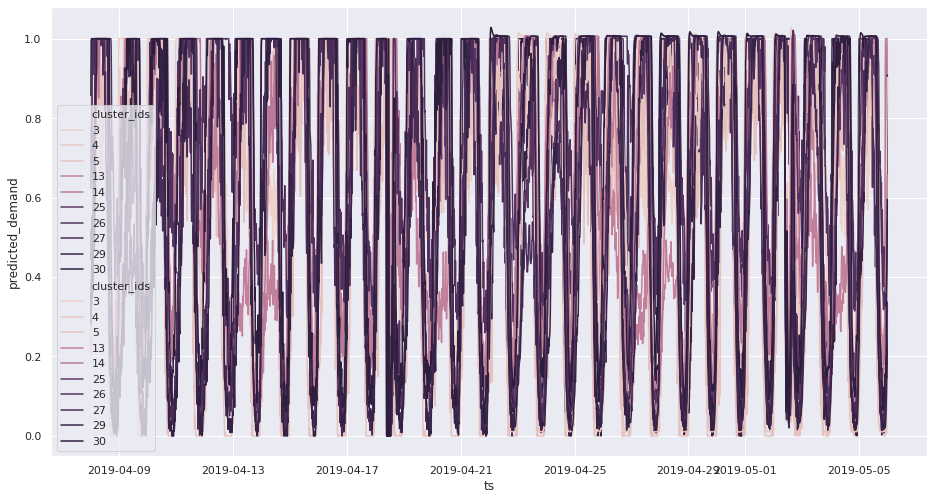

In [67]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")
ax = sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")

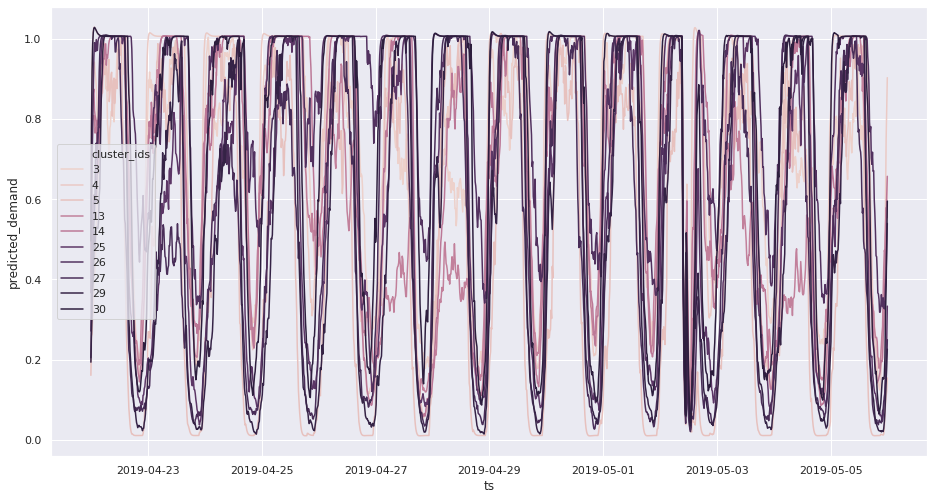

In [68]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", data=top_result_df, legend="full")
plt.show()

# find predicted demand of a geohash point by datetime

In [69]:
def measure_distance(x1, y1, x2, y2):
    R = 6373.0

    lat1 = radians(x1)
    lon1 = radians(y1)
    lat2 = radians(x2)
    lon2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [70]:
trf_day1[(trf_day1.is_centroid == False) & (trf_day1.highest_demand == False)].sort_values(['dts_cal'])

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
2271890,qp03tm,8,0:0,0.001944,2019-04-08 00:00:00,"(-5.33111572265625, 90.5877685546875)",-5.331116,90.587769,6,False,False,0.007004
2129089,qp09df,8,0:0,0.086511,2019-04-08 00:00:00,"(-5.34759521484375, 90.8294677734375)",-5.347595,90.829468,27,False,False,0.126311
2198539,qp094g,8,0:0,0.053183,2019-04-08 00:00:00,"(-5.42999267578125, 90.8294677734375)",-5.429993,90.829468,27,False,False,0.036120
2758566,qp094c,8,0:0,0.053116,2019-04-08 00:00:00,"(-5.44097900390625, 90.8294677734375)",-5.440979,90.829468,27,False,False,0.056692
3612467,qp094y,8,0:0,0.050412,2019-04-08 00:00:00,"(-5.41351318359375, 90.8294677734375)",-5.413513,90.829468,27,False,False,0.035537
3027750,qp09ue,8,0:0,0.310892,2019-04-08 00:00:00,"(-5.29815673828125, 90.9063720703125)",-5.298157,90.906372,48,False,False,0.120552
2938024,qp09sd,8,0:0,0.306278,2019-04-08 00:00:00,"(-5.34759521484375, 90.9063720703125)",-5.347595,90.906372,48,False,False,0.140571
3359815,qp09sx,8,0:0,0.247511,2019-04-08 00:00:00,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372,48,False,False,0.103043
2760033,qp09se,8,0:0,0.172183,2019-04-08 00:00:00,"(-5.34210205078125, 90.9063720703125)",-5.342102,90.906372,48,False,False,0.149126
652971,qp09u8,8,0:0,0.157024,2019-04-08 00:00:00,"(-5.31463623046875, 90.9063720703125)",-5.314636,90.906372,48,False,False,0.073993


In [71]:
# prepare data day n+(n/2) for evaluation
initial_week3 = day_ids[-1] + 1
num_of_days = int(len(day_ids) / 2)
trf_week3 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_week3) & (trf_df_sort.day < (initial_week3 + num_of_days))])
trf_week3 = trf_week3.sort_values(['geohash6', 'dts_cal'])
geohash_list = list(set([c for c in trf_week3['geohash6']]))

trf_week3_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': []})
interval_time = [datetime.timedelta(days=initial_week3,minutes=15*t) for t in range(24*4*num_of_days)]
gh = trf_week3.groupby(['geohash6', 'dts_cal'])['geohash6'].apply(list)
demand = trf_week3.groupby(['geohash6', 'dts_cal'])['demand'].apply(list)

trf_week3_complete['geohash6'] = [gh[c][0][0] for _ in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in geohash_list]
trf_week3_complete['day'] = [initial_week3 + int(t/(24*4)) for t in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in geohash_list]
trf_week3_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in geohash_list]
trf_week3_complete

,geohash6,day,timestamp,demand,dts_cal
0,qp03r6,36,0:0,0.103776,2019-05-06 00:00:00
1,qp08fy,36,0:0,0.039338,2019-05-06 00:00:00
2,qp095s,36,0:0,0.039656,2019-05-06 00:00:00
3,qp09ge,36,0:0,0.032588,2019-05-06 00:00:00
4,qp09wp,36,0:0,0.000000,2019-05-06 00:00:00
5,qp0d4g,36,0:0,0.000000,2019-05-06 00:00:00
6,qp0dhd,36,0:0,0.000000,2019-05-06 00:00:00
7,qp08b7,36,0:0,0.014350,2019-05-06 00:00:00
8,qp0dn0,36,0:0,0.000000,2019-05-06 00:00:00
9,qp03ws,36,0:0,0.262298,2019-05-06 00:00:00


In [72]:
# find input point's distance from centermost
input_point = 'qp09ux' # 1 cluster sample
input_point = 'qp096h'
#input_point = 'qp09hm'
latlon = geohash.decode(input_point)
trf_day1_dist = pd.DataFrame(trf_day1)
trf_day1_dist['distance'] = trf_day1_dist.latlon.apply(lambda latlon2: measure_distance(latlon[0], latlon[1], latlon2[0], latlon2[1]))
trf_day1_dist = trf_day1_dist.sort_values(['distance', 'dts_cal'])
search_cluster = trf_day1_dist['cluster_ids'].iloc[0]
data_sample = trf_day1_complete[(trf_day1_complete.cluster_ids == search_cluster) & (trf_day1_complete.highest_demand == True)]
sample_geohash = data_sample['geohash6'].iloc[0]
trf_week3_eval = trf_week3[(trf_week3.geohash6 == sample_geohash)]

interval=64
first_idx = range(0, interval)
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]

X_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
y_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[total_sequence_series-prediction_length:])] for _ in first_idx]]
predicted_actual_data = model.predict(X_actual_data, batch_size=interval)

eval_sample = trf_week3_complete[trf_week3_complete.geohash6 == sample_geohash]
X_eval_data = predicted_actual_data
y_eval_data = [[[[eval_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
predicted_eval_data = model.predict(X_eval_data, batch_size=interval)


# actual vs predicted per cluster highest demand

In [73]:
X_actual_df = pd.DataFrame([X_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_actual_df = pd.DataFrame([y_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
X_predicted_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in first_idx[:1]])
y_predicted_df = pd.DataFrame([predicted_actual_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

y_eval_df = pd.DataFrame([y_eval_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_predicted_eval_df = pd.DataFrame([predicted_eval_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

ext_interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*(multiplier+num_of_days))]

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'predicted_50_quant': [],
    'predicted_90_quant': [],
    'ts': []})

result_df['ts'] = [start_date + t for t in ext_interval_time for _ in first_idx[:1]]
#result_df['ts'] = [datetime.datetime.timestamp(start_date + t) for t in ext_interval_time for _ in first_idx[:1]]
#print(len([start_date + t for t in ext_interval_time for _ in first_idx[:1]]))

#rng = pd.date_range('2019-04-01 00:00:00', periods=24*4*(multiplier+num_of_days), freq='15min')
#result_df['ts'] = rng
#result_df.set_index(['ts'])
#result_df.index = pd.to_datetime(result_df.index, unit='s')

actual_result = X_actual_df.append(y_actual_df).append(y_eval_df)
predicted_result = X_predicted_df.append(y_predicted_df).append(y_predicted_eval_df)
result_df = result_df.sort_values(['ts'])
result_df['ts'] = pd.to_datetime(result_df.ts)
result_df.index = pd.DatetimeIndex(result_df.ts)
result_df.set_index('ts')
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

g = result_df.groupby([pd.Grouper(freq='H')])
result_df['predicted_50_quant'] = g.quantile(0.50)['predicted_demand']
result_df['predicted_90_quant'] = g.quantile(0.90)['predicted_demand']

result_df
#melted_df = pd.melt(result_df, id_vars=[], 
#                   value_vars=result_df['ts'],
#                   value_name='predicted_demand',
#                   var_name=['ts'])
#melted_df

,actual_demand,predicted_demand,predicted_50_quant,predicted_90_quant,ts
ts,,,,,
2019-04-08 00:00:00,0.164922,NaN,NaN,NaN,2019-04-08 00:00:00
2019-04-08 00:15:00,0.138322,NaN,NaN,NaN,2019-04-08 00:15:00
2019-04-08 00:30:00,0.094098,NaN,NaN,NaN,2019-04-08 00:30:00
2019-04-08 00:45:00,0.160861,NaN,NaN,NaN,2019-04-08 00:45:00
2019-04-08 01:00:00,0.099582,NaN,NaN,NaN,2019-04-08 01:00:00
2019-04-08 01:15:00,0.186853,NaN,NaN,NaN,2019-04-08 01:15:00
2019-04-08 01:30:00,0.233142,NaN,NaN,NaN,2019-04-08 01:30:00
2019-04-08 01:45:00,0.167394,NaN,NaN,NaN,2019-04-08 01:45:00
2019-04-08 02:00:00,0.135599,NaN,NaN,NaN,2019-04-08 02:00:00


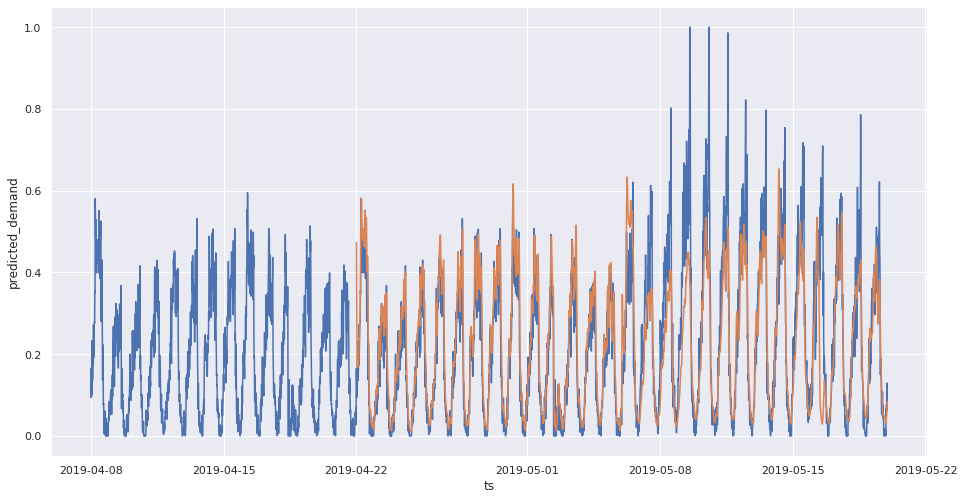

In [74]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", data=result_df, ax=ax)
ax = sns.lineplot(x="ts", y="predicted_demand", data=result_df, ci="sd", err_style="band", ax=ax)
#ax = sns.lineplot(x="ts", y="predicted_50_quant", data=result_df, ci=50, ax=ax, legend="full")
#ax = sns.lineplot(x="ts", y="predicted_90_quant", data=result_df, ci=90, ax=ax, legend="full")
#sns.tsplot([result_df.actual_demand, result_df.predicted_demand])